# PROJECT BLOCK 2: Advanced Stadistics

### Carlos Eduardo Ortega Clement A01707480

##  Part 2 - Forecasting Queretaro industrial activity

### You have to design an ARIMA-SARIMA model to forecast the Querétaro “Indice de Actividad Industrial”. INEGI publishes a monthly index of the industrial activity for each state and at the national level. You can download this index Googling it (“inegi bie índice de actividad industrial Querétaro”)

In [1]:
import pandas as pd
import numpy as np

# data de la industria de qro
data = pd.read_csv('IAI_QRO.csv')

# transformamos los datos a logaritmo para reducir la varianza de los mismos
data['lnqro'] = np.log(data['Valor'])
data


,Periodo,Valor,lnqro
0,2003/01,65.234491,4.177988
1,2003/02,64.750420,4.170540
2,2003/03,61.444991,4.118142
3,2003/04,64.953065,4.173665
4,2003/05,59.522348,4.086352
...,...,...,...
241,2023/02,89.168194,4.490524
242,2023/03,103.384331,4.638453
243,2023/04,91.876916,4.520450
244,2023/05,101.002534,4.615146


## Paso 2: Visualizar los datos
### Procedemos a visualizar la serie temporal para comprender mejor la variación a lo largo del tiempo.

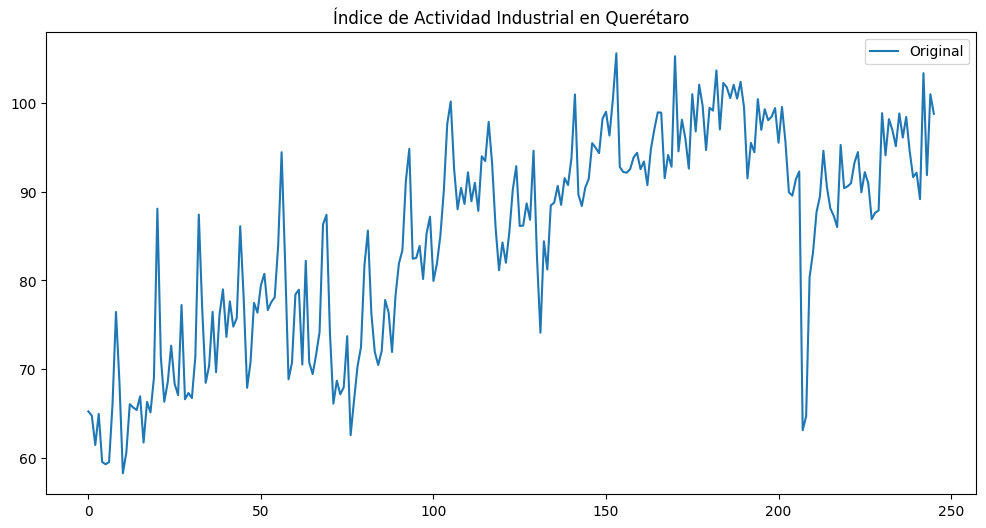

In [2]:
import matplotlib.pyplot as plt

# Visualizar los datos
plt.figure(figsize=(12, 6))
plt.plot(data['Valor'], label='Original')
plt.title('Índice de Actividad Industrial en Querétaro')
plt.legend()
plt.show()


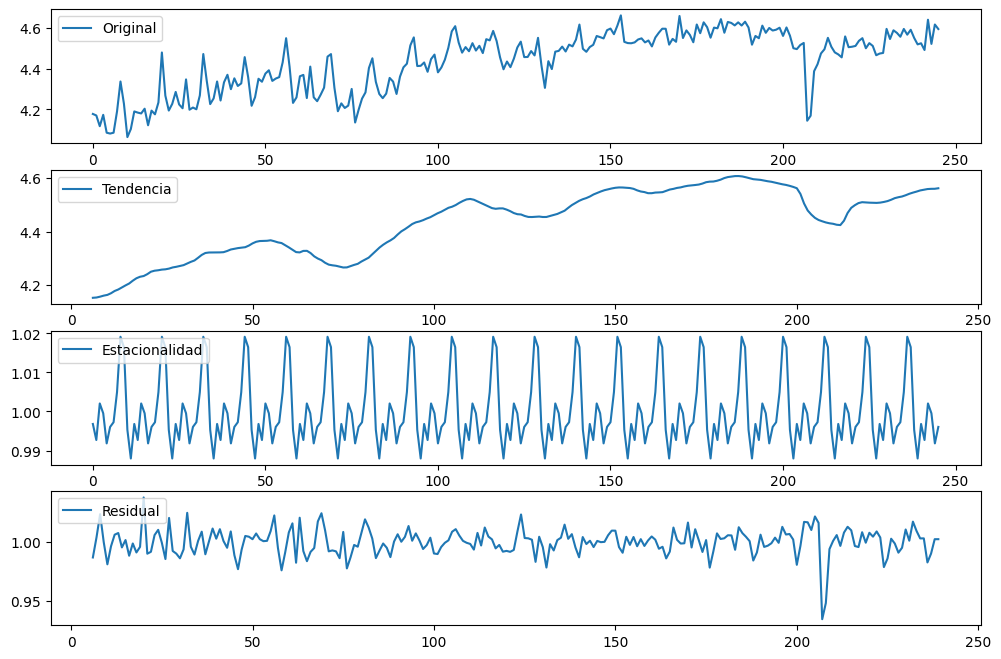

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposición de la serie temporal
decomposition = seasonal_decompose(data['lnqro'], model='multiplicative', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualizar componentes descompuestas
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['lnqro'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.show()

## Paso 3: Verificar estacionariedad
### Antes de modelar, verificamos la estacionariedad de la serie temporal utilizando la prueba ADF (Augmented Dickey-Fuller). Esto es crucial para aplicar modelos ARIMA-SARIMA.

In [4]:
from statsmodels.tsa.stattools import adfuller

# Verificar estacionariedad
result = adfuller(data['lnqro'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.040270040636772
p-value: 0.2691998522695339


Interpretación:

El estadístico ADF es menor que el valor crítico, y el valor p es mayor que 0.05. En general, si el estadístico ADF es más negativo que los valores críticos y el valor p es mayor que 0.05, no podemos rechazar la hipótesis nula de no estacionariedad. En este caso, el p-value es significativamente mayor que 0.05, lo que sugiere que no podemos rechazar la hipótesis nula de no estacionariedad. Por lo tanto, la serie temporal no parece ser estacionaria en su forma actual.

Dado que la serie no es estacionaria, será necesario aplicar diferenciación para hacerla estacionaria antes de proceder con la modelización ARIMA-SARIMA.

. La diferenciación implica restar el valor anterior al valor actual en la serie temporal. Podemos lograr esto mediante la creación de una nueva columna que represente la diferencia entre las observaciones consecutivas.







In [5]:
# Aplicar la diferencia estacional del logaritmo

data['ydiff']= data['lnqro']  - data['lnqro'].shift(12)
data.head(20)


,Periodo,Valor,lnqro,ydiff
0,2003/01,65.234491,4.177988,NaN
1,2003/02,64.750420,4.170540,NaN
2,2003/03,61.444991,4.118142,NaN
3,2003/04,64.953065,4.173665,NaN
4,2003/05,59.522348,4.086352,NaN
5,2003/06,59.273040,4.082155,NaN
6,2003/07,59.521204,4.086333,NaN
7,2003/08,66.044043,4.190322,NaN
8,2003/09,76.448073,4.336612,NaN
9,2003/10,68.567827,4.227823,NaN


In [23]:
#Hacemos un drop de los valores Nan para los analisis posteriores.

data_wn = data.copy().dropna()
data_wn

,Periodo,Valor,lnqro,ydiff
12,2004/01,66.045678,4.190347,0.012358
13,2004/02,65.668412,4.184618,0.014078
14,2004/03,65.394662,4.180441,0.062298
15,2004/04,66.930978,4.203662,0.029997
16,2004/05,61.722965,4.122656,0.036304
...,...,...,...,...
241,2023/02,89.168194,4.490524,0.014323
242,2023/03,103.384331,4.638453,0.044631
243,2023/04,91.876916,4.520450,-0.023967
244,2023/05,101.002534,4.615146,0.028219


In [7]:
# ahora si volvemos a realizar la prueba con la diferencia (ydiff) para verificar la estacionariedad

from statsmodels.tsa.stattools import adfuller

# Verificar estacionariedad
result = adfuller(data_wn['ydiff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.3992926592455004
p-value: 0.010983008452611681


Se puede observar que el p value ya es menor a 0.05 por lo que se puede rechazar la hipótesis nula.  se ha tenido en cuenta la estacionalidad en los datos, y al establecer D=1
, indicamos que se ha realizado una diferencia estacional de primer orden para lograr la estacionariedad. 


## Paso 4: Identificar parámetros ARIMA-SARIMA con ACF y PACF

## Paso 5: Calibrar el modelo ARIMA-SARIMA

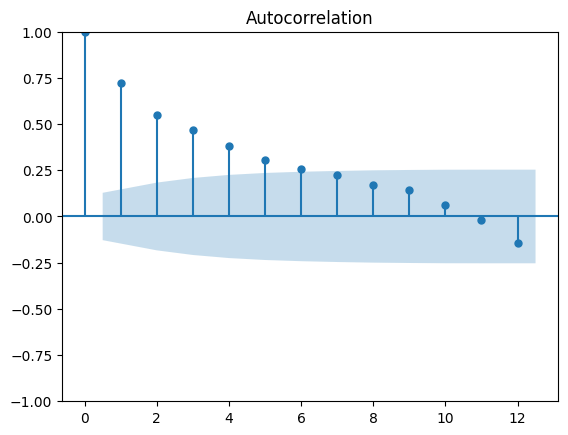

In [8]:
# Gráfico de autocorrelación con 12 lags
# esto para observar cómo se comporta con los otros meses del año.
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(data_wn['ydiff'], lags = 12)
plt.show()

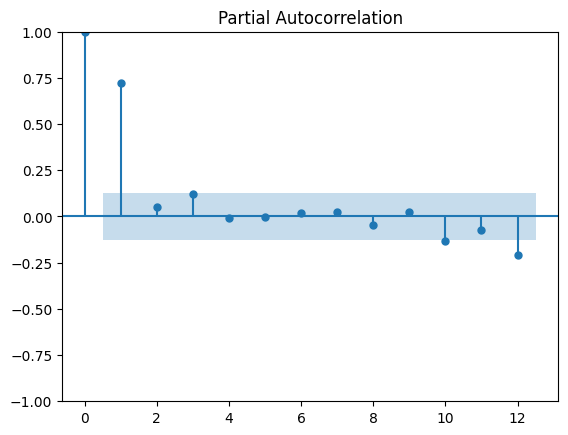

In [9]:
import warnings

# Ignoramos los warnings
warnings.filterwarnings("ignore")


from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_wn['ydiff'], lags=12)
plt.show()

Se llevó a cabo un análisis de la función de autocorrelación parcial (PACF) para la serie temporal de Querétaro. Al observar el gráfico PACF, se identifica una influencia significativa del mes actual con el mes anterior, indicando que el lag 11 tiene un impacto en el lag 12. Este patrón sugiere una relación relevante entre el mes actual y el mes inmediatamente anterior.

La asignación de  p como 1 se fundamenta en este análisis, lo cual significa que, al realizar predicciones para el mes actual, se tiene en cuenta solo la observación del mes anterior. Este enfoque contribuye a una modelización más precisa de la estructura temporal de los datos de Querétaro.

In [25]:
import statsmodels.api as sm

p = 1; d = 0; q = 0; P = 0; D = 1; Q = 0; s = 12

model_1 = sm.tsa.statespace.SARIMAX(data_wn['lnqro'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c')
model_1f = model_1.fit(disp = 0, method='bfgs')

print(model_1f.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              lnqro   No. Observations:                  234
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 313.098
Date:                            Sat, 18 Nov 2023   AIC                           -620.196
Time:                                    00:33:06   BIC                           -609.988
Sample:                                         0   HQIC                          -616.074
                                            - 234                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.004      1.355      0.175      -0.002       0.013
ar.L1          0.7241      0.035   

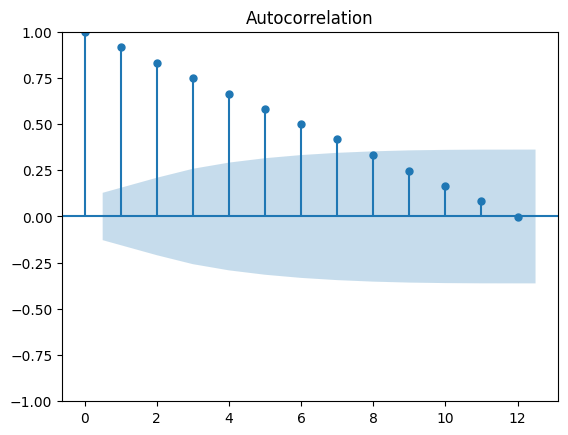

In [26]:
plot_acf(model_1f.resid, lags = 12)
plt.show()

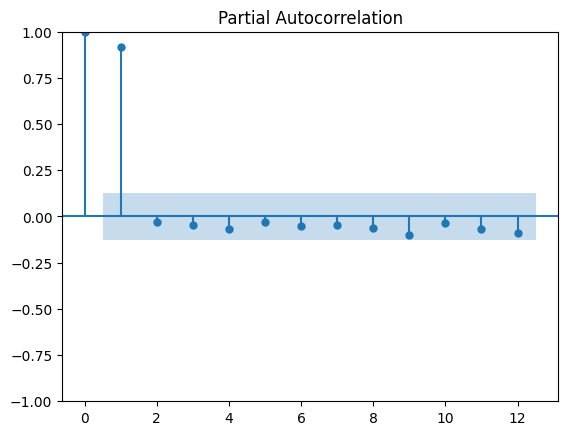

In [27]:
plot_pacf(model_1f.resid, lags = 12)
plt.show()

En el análisis del modelo SARIMA realizado, se observa que el gráfico de funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) resulta más claro y revelador. A pesar de una correlación significativa en el primer lag, que indica que podríamos incluir un término q igual a 1, se destaca la utilidad de utilizar un enfoque de modelo SARIMA. Este enfoque permite incorporar un error pronosticado con un lag en el modelo, lo que contribuye a una mejor captura de la estructura temporal de los datos.

En particular, al asignar q=1, se está utilizando un error pronosticado con un lag para mejorar las predicciones del modelo, lo cual se refleja en la forma en que se manejan las autocorrelaciones y parcial autocorrelaciones de los residuos. Estos resultados respaldan la elección de parámetros y subrayan la eficacia del modelo SARIMA en este contexto específico de series temporales.

In [28]:
p = 1; d = 0; q = 1; P = 0; D = 1; Q = 0; s = 12

model_2 = sm.tsa.statespace.SARIMAX(data_wn['lnqro'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c', simple_differencing = True)
model_2f = model_2.fit(disp = 0, method='bfgs')

print(model_2f.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          DS12.lnqro   No. Observations:                  222
Model:             SARIMAX(1, 0, 1)x(0, 0, [], 12)   Log Likelihood                 313.259
Date:                             Sat, 18 Nov 2023   AIC                           -618.519
Time:                                     00:33:36   BIC                           -604.908
Sample:                                          0   HQIC                          -613.024
                                             - 222                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.004      1.293      0.196      -0.002       0.012
ar.L1          0.7540      

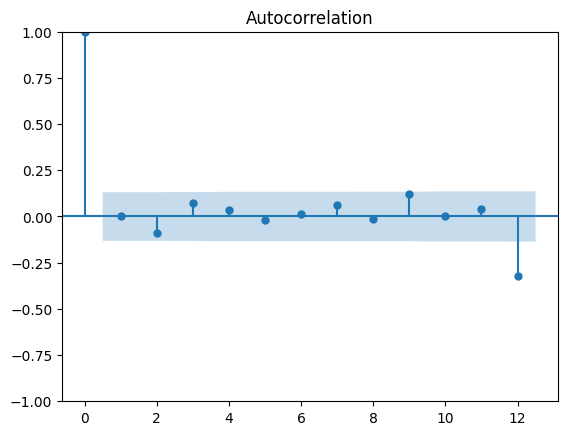

In [29]:
plot_acf(model_2f.resid, lags = 12)
plt.show()

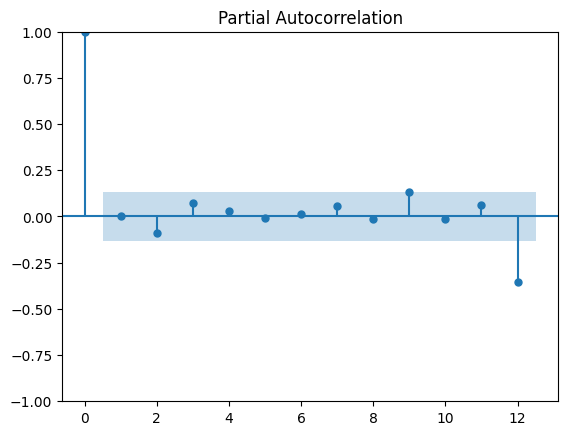

In [30]:
plot_pacf(model_2f.resid, lags = 12)
plt.show()



Se observa una mejora en la reducción de la autocorrelación parcial en el primer lag, aunque ahora se presenta un aumento notable en el duodécimo lag. Este cambio sugiere la necesidad de incluir un término  Q=1 en nuestro modelo para incorporar un lag del error estacional en las predicciones. Este ajuste adicional permitirá tener en cuenta las fluctuaciones estacionales y mejorar la capacidad del modelo para capturar la estructura temporal de los datos.

In [62]:
p = 1; d = 0; q = 1; P = 0; D = 1; Q = 1; s = 12

model_3= sm.tsa.statespace.SARIMAX(data_wn['lnqro'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c', simple_differencing = True)
model_3f = model_3.fit(disp = 0, method='bfgs')

print(model_3f.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         DS12.lnqro   No. Observations:                  222
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 338.774
Date:                            Sat, 18 Nov 2023   AIC                           -667.549
Time:                                    00:44:05   BIC                           -650.535
Sample:                                         0   HQIC                          -660.680
                                            - 222                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.002      1.766      0.077      -0.000       0.006
ar.L1          0.8370      0.050   

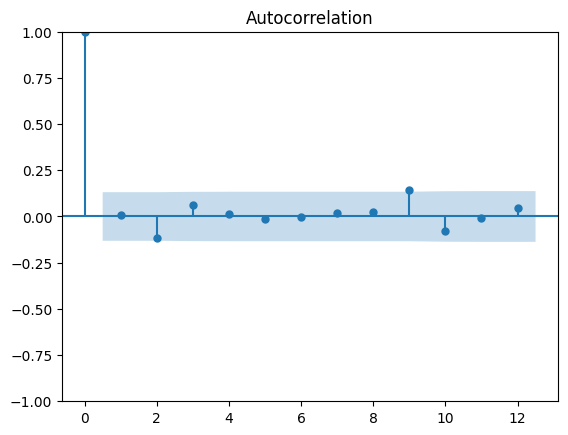

In [63]:
plot_acf(model_3f.resid, lags = 12)
plt.show()

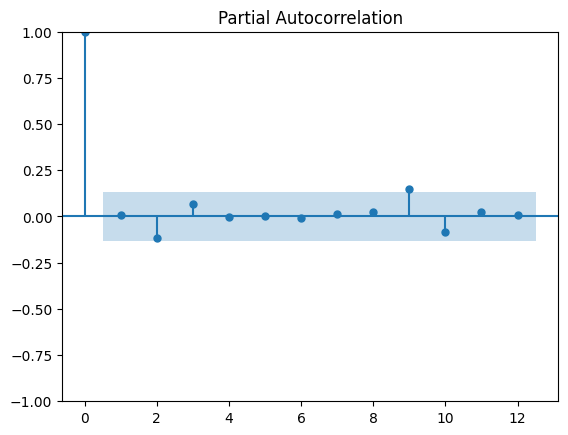

In [64]:
plot_pacf(model_3f.resid, lags = 12)
plt.show()

El modelo SARIMAX con parámetros (1, 0, 1)x(0, 0, 1, 12) captura patrones temporales clave en la transformación logarítmica de la variable 'lnqro'. Aunque el intercepto es aproximadamente 0.0029 y no es estadísticamente significativo a un nivel de significancia del 0.05 (valor p = 0.077), agrega un término constante al modelo. El término autorregresivo (AR) con un coeficiente estimado de 0.8370 sugiere una correlación positiva sólida entre el valor actual y el valor del período anterior (lags 1), respaldado por su valor p altamente significativo (< 0.001). Simultáneamente, el término de media móvil (MA) con un coeficiente de -0.1681, aunque estadísticamente significativo (valor p = 0.044), indica una correlación negativa entre los errores actuales y anteriores (lags 1). Notablemente, el término de media móvil estacional (SMA) con una estimación de -0.5851 es altamente significativo, enfatizando la capacidad del modelo para capturar dependencias estacionales con lags de 12.

El error estándar residual, alrededor de 0.0027, representa la precisión del modelo para explicar la variabilidad en la variable transformada. En general, el modelo SARIMAX incorpora de manera efectiva dependencias en lags y patrones estacionales, proporcionando un marco estadísticamente significativo para predecir 'lnqro' basándose en su comportamiento histórico.


## Paso 5: Calibrar el modelo ARIMA-SARIMA

### You have to forecast the industrial index for Querétaro up to 2030. What is the expected average annual growth for 6-7 years?

In [120]:
import pandas as pd

# Generar el rango de fechas
forecast_index = pd.date_range(start='2024-01-01', end='2030-12-01', freq='M')

# Crear DataFrame de predicciones
forecast_data = pd.DataFrame({'Periodo': forecast_index, 'Prediction': [np.nan] * len(forecast_index)})

# Concatenar con el DataFrame original
forecast = pd.concat([data, forecast_data], ignore_index=True)

forecast

,Periodo,Valor,lnqro,ydiff,Prediction
0,2003/01,65.234491,4.177988,NaN,NaN
1,2003/02,64.750420,4.170540,NaN,NaN
2,2003/03,61.444991,4.118142,NaN,NaN
3,2003/04,64.953065,4.173665,NaN,NaN
4,2003/05,59.522348,4.086352,NaN,NaN
...,...,...,...,...,...
324,2030-07-31 00:00:00,NaN,NaN,NaN,NaN
325,2030-08-31 00:00:00,NaN,NaN,NaN,NaN
326,2030-09-30 00:00:00,NaN,NaN,NaN,NaN
327,2030-10-31 00:00:00,NaN,NaN,NaN,NaN


In [121]:
predictions = model_3f.get_forecast(steps = 100)
forecast['Prediction'] = predictions.predicted_mean
forecast = forecast.set_index(['Periodo'], drop=True)
forecast.head(20)


,Valor,lnqro,ydiff,Prediction
Periodo,,,,
2003/01,65.234491,4.177988,NaN,NaN
2003/02,64.750420,4.170540,NaN,NaN
2003/03,61.444991,4.118142,NaN,NaN
2003/04,64.953065,4.173665,NaN,NaN
2003/05,59.522348,4.086352,NaN,NaN
2003/06,59.273040,4.082155,NaN,NaN
2003/07,59.521204,4.086333,NaN,NaN
2003/08,66.044043,4.190322,NaN,NaN
2003/09,76.448073,4.336612,NaN,NaN


In [122]:
forecast.drop('lnqro', axis = 1, inplace = True)
forecast.drop('Valor', axis = 1, inplace = True)


In [123]:
forecast.head()




,ydiff,Prediction
Periodo,,
2003/01,NaN,NaN
2003/02,NaN,NaN
2003/03,NaN,NaN
2003/04,NaN,NaN
2003/05,NaN,NaN


<Axes: xlabel='Periodo'>

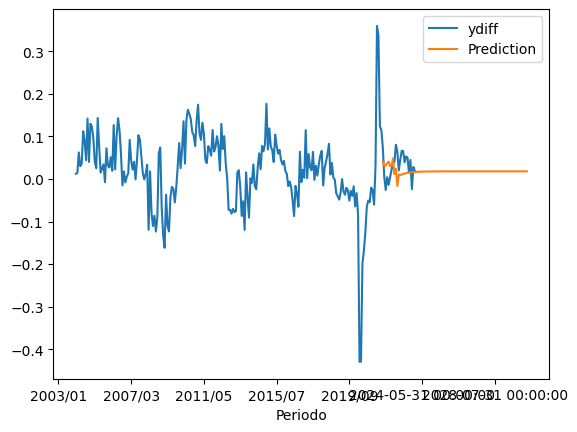

In [124]:
forecast.plot()

 A pesar de haber hecho el modelo con un análisis detallado, no se obtuvieron los resultados esperados en las predicciones del modelo.